In [27]:
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
import numpy as np
from six.moves import range
import matplotlib.pyplot as plt

# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [52]:
TRAINING_SIZE = 100000
DIGITS = 3
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789+- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 2

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '+',
 2: '-',
 3: '0',
 4: '1',
 5: '2',
 6: '3',
 7: '4',
 8: '5',
 9: '6',
 10: '7',
 11: '8',
 12: '9'}

# Data Generation

In [7]:
def generateData(opTypes):
    questions = []
    expected = []
    seen = set()
    print('Generating data...')
    while len(questions) < TRAINING_SIZE:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
        a, b = f(), f()
        if len(opTypes) > 1:
            opType = np.random.choice(list(opTypes))
        else:
            opType = opTypes
        key = tuple(sorted((a, b))) + tuple(opTypes)
        if key in seen:
            continue
        seen.add(key)
        q = '{}{}{}'.format(a,opType,b)
        query = q + ' ' * (MAXLEN - len(q))
        if opType == '+':
            ans = str(a + b)
        else:
            ans = str(a - b)
        ans += ' ' * (DIGITS + 1 - len(ans))
        if REVERSE:
            query = query[::-1]
        questions.append(query)
        expected.append(ans)
    print('Done!')
    print(questions[:5], expected[:5])
    return questions, expected
    
# questions, expected = generateData('-+')

# Processing

In [8]:
def vectorization(questions, expected):
    print('Vectorization...')
    x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
    y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        x[i] = ctable.encode(sentence, MAXLEN)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, DIGITS + 1)
    print('Done!')
    return x, y

# x, y = vectorization(questions, expected)

In [9]:
def train_test_split(x, y, train_size):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    # train_test_split
    train_x = x[:train_size]
    train_y = y[:train_size]
    test_x = x[train_size:]
    test_y = y[train_size:]

    split_at = len(train_x) - len(train_x) // 10
    (x_train, x_val) = train_x[:split_at], train_x[split_at:]
    (y_train, y_val) = train_y[:split_at], train_y[split_at:]
    
    print('Training Data:')
    print(x_train.shape)
    print(y_train.shape)

    print('Validation Data:')
    print(x_val.shape)
    print(y_val.shape)

    print('Testing Data:')
    print(test_x.shape)
    print(test_y.shape)
    
    return x_train, y_train, x_val, y_val, test_x, test_y

# x_train, y_train, x_val, y_val, test_x, test_y = train_test_split(x, y, 40000)

# Build Model

In [10]:
def buildModel():
    print('Build model...')
    model = Sequential()
    model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
    model.add(layers.RepeatVector(DIGITS + 1))
    for i in range(LAYERS):
        model.add(RNN(HIDDEN_SIZE, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(len(chars))))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

# adder = buildModel()

# Training

In [45]:
def trainModel(model, x_train, y_train, x_val, y_val, test_x, test_y):
    acc_record = []
    for iteration in range(100):
        print()
        print('-' * 50)
        print('Iteration', iteration)
        model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=1,
                  validation_data=(x_val, y_val))
        acc = evaluate(model, test_x, test_y)
        acc_record.append(acc)
        if acc > 0.95:
            break
    return model, acc_record

# adder = trainModel(adder, x_train, y_train, x_val, y_val)

# Testing

In [37]:
def evaluate(model, test_x, test_y):
    num_corrects = 0
    prediction = model.predict_classes(test_x)
    for i in range(len(prediction)):
        ans = ctable.decode(test_y[i])
        guess = ctable.decode(prediction[i], calc_argmax=False)
        if ans == guess:
            num_corrects += 1
    print("Accuracy: {}".format(num_corrects / len(prediction)))
    return float(num_corrects / len(prediction))
    
# evaluate(adder, test_x, test_y)

In [38]:
def plot(record):
    plt.plot(record)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

# The Adder
* Operator: '+'
* Training Data: 18000
* Validation Data: 2000
* Testing Data: 80000
* Digits: 3

Generating data...
Done!
['969+8  ', '5+5    ', '9+19   ', '37+1   ', '28+4   '] ['977 ', '10  ', '28  ', '38  ', '32  ']
Vectorization...
Done!
Training Data:
(18000, 7, 13)
(18000, 4, 13)
Validation Data:
(2000, 7, 13)
(2000, 4, 13)
Testing Data:
(80000, 7, 13)
(80000, 4, 13)
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               72704     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 4, 13)             1677      
_________________________________________________________________
activation_6 (Activation)    (None, 4, 13)    

18000/18000 [==============================] - 4s 197us/step - loss: 0.7809 - acc: 0.7141 - val_loss: 0.7757 - val_acc: 0.7121
Accuracy: 0.1994

--------------------------------------------------
Iteration 26
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 213us/step - loss: 0.6964 - acc: 0.7473 - val_loss: 0.6824 - val_acc: 0.7429
Accuracy: 0.275075

--------------------------------------------------
Iteration 27
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 201us/step - loss: 0.6169 - acc: 0.7842 - val_loss: 0.6053 - val_acc: 0.7785
Accuracy: 0.357825

--------------------------------------------------
Iteration 28
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 199us/step - loss: 0.5415 - acc: 0.8213 - val_loss: 0.5311 - val_acc: 0.8248
Accuracy: 0.450375

---------------------------------------------

Accuracy: 0.93035

--------------------------------------------------
Iteration 56
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 234us/step - loss: 0.0496 - acc: 0.9929 - val_loss: 0.2673 - val_acc: 0.9260
Accuracy: 0.7738

--------------------------------------------------
Iteration 57
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 4s 237us/step - loss: 0.0973 - acc: 0.9720 - val_loss: 0.0793 - val_acc: 0.9789
Accuracy: 0.9235625

--------------------------------------------------
Iteration 58
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 5s 252us/step - loss: 0.0432 - acc: 0.9947 - val_loss: 0.0735 - val_acc: 0.9807
Accuracy: 0.9288875

--------------------------------------------------
Iteration 59
Train on 18000 samples, validate on 2000 samples
Epoch 1/1
18000/18000 [==============================] - 5

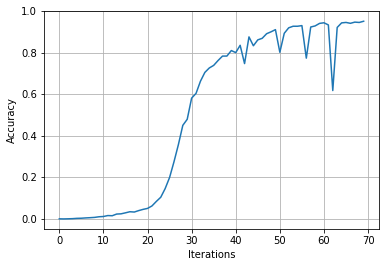

In [35]:
opType = '+'
trainSize = 20000
questions, expected = generateData(opType)
x, y = vectorization(questions, expected)
x_train, y_train, x_val, y_val, test_x, test_y = train_test_split(x, y, trainSize)
adder = buildModel()
adder, acc_record = trainModel(adder, x_train, y_train, x_val, y_val, test_x, test_y)
# evaluate(adder, test_x, test_y)